# Add expansion output to low-rate aging simulation

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"

# %matplotlib widget

In [2]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [3]:
parameter_values.search("Li")

Cell cooling surface area [m2]	0.41
Initial plated lithium concentration [mol.m-3]	0.0
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Lithium interstitial reference concentration [mol.m-3]	15.0
Lithium metal partial molar volume [m3.mol-1]	1.3e-05
Typical lithium ion diffusivity [m2.s-1]	5.34e-10
Typical plated lithium concentration [mol.m-3]	1000.0


In [4]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

In [5]:
def cycle_adaptive_simulation(model, parameter_values, experiment,SOC_0=1, save_at_cycles=None):
    experiment_one_cycle = pybamm.Experiment(
        experiment.operating_conditions_cycles[:1],
        termination=experiment.termination_string,
        cccv_handling=experiment.cccv_handling,
    )
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)
    n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
                "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            
        }
    )

    sim_ode = pybamm.Simulation(
        model, experiment=experiment_one_cycle, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol0 = sim_ode.solve(initial_soc=SOC_0)
    model = sim_ode.solution.all_models[0]
    cap0 = sol0.summary_variables["Capacity [A.h]"]

    def sol_to_y(sol, loc="end"):
        if loc == "start":
            pos = 0
        elif loc == "end":
            pos = -1
        model = sol.all_models[0]
        n_Li = sol["Total lithium in particles [mol]"].data[pos].flatten()
        Cn = sol["Negative electrode capacity [A.h]"].data[pos].flatten()
        Cp = sol["Positive electrode capacity [A.h]"].data[pos].flatten()
        # y = np.concatenate([n_Li, Cn, Cp])
        y = n_Li
        for var in model.initial_conditions:
            if var.name not in [
                "X-averaged negative particle concentration",
                "X-averaged positive particle concentration",
                "Discharge capacity [A.h]",
            ]:
                value = sol[var.name].data
                if value.ndim == 1:
                    value = value[pos]
                elif value.ndim == 2:
                    value = value[:, pos]
                elif value.ndim == 3:
                    value = value[:, :, pos]
                y = np.concatenate([y, value.flatten()])
        return y

    def y_to_sol(y, esoh_sim, model):
        n_Li = y[0]
        Cn = C_over_eps_n * y[1]
        Cp = C_over_eps_p * y[2]

        esoh_sol = esoh_sim.solve(
            [0],
            inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
        )
        esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
        ics = {}
        x_100 = esoh_sol["x_100"].data[0]
        y_100 = esoh_sol["y_100"].data[0]
        x_0 = esoh_sol["x_0"].data[0]
        y_0 = esoh_sol["y_0"].data[0]
        start = 1
        for var in model.initial_conditions:
            if var.name == "X-averaged negative particle concentration":
                ics[var.name] = ((x_100-x_0)*SOC_0+x_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "X-averaged positive particle concentration":
                ics[var.name] = ((y_100-y_0)*SOC_0+y_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "Discharge capacity [A.h]":
                ics[var.name] = np.zeros(1)
            else:
                end = start + model.variables[var.name].size
                ics[var.name] = y[start:end, np.newaxis]
                start = end
        model.set_initial_conditions_from(ics)
        return pybamm.Solution(
            [np.array([0])],
            model.concatenated_initial_conditions.evaluate()[:, np.newaxis],
            model,
            {},
        )

    def dydt(t, y):
        if y[0] < 0 or y[1] < 0 or y[2] < 0:
            return 0 * y

        print(t)
        # Set up based on current value of y
        y_to_sol(
            y,
            esoh_sim,
            sim_ode.op_conds_to_built_models[
                experiment_one_cycle.operating_conditions[0]["electric"]
            ],
        )

        # Simulate one cycle
        sol = sim_ode.solve()

        dy = sol_to_y(sol) - y

        return dy

    if experiment.termination == {}:
        event = None
    else:

        def capacity_cutoff(t, y):
            sol = y_to_sol(y, esoh_sim, model)
            cap = pybamm.make_cycle_solution([sol], esoh_sim, True)[1]["Capacity [A.h]"]
            return cap / cap0 - experiment_one_cycle.termination["capacity"][0] / 100

        capacity_cutoff.terminal = True

    num_cycles = len(experiment.operating_conditions_cycles)
    if save_at_cycles is None:
        t_eval = np.arange(1, num_cycles + 1)
    elif save_at_cycles == -1:
        t_eval = None
    else:
        t_eval = np.arange(1, num_cycles + 1, save_at_cycles)
    y0 = sol_to_y(sol0, loc="start")
    timer = pybamm.Timer()
    sol = solve_ivp(
        dydt,
        [1, num_cycles],
        y0,
        t_eval=t_eval,
        events=capacity_cutoff,
        first_step=10,
        method="RK23",
        atol=1e-2,
        rtol=1e-2,
    )
    time = timer.time()

    all_sumvars = []
    for idx in range(sol.y.shape[1]):
        fullsol = y_to_sol(sol.y[:, idx], esoh_sim, model)
        sumvars = pybamm.make_cycle_solution([fullsol], esoh_sim, True)[1]
        all_sumvars.append(sumvars)

    all_sumvars_dict = {
        key: np.array([sumvars[key] for sumvars in all_sumvars])
        for key in all_sumvars[0].keys()
    }
    all_sumvars_dict["Cycle number"] = sol.t
    
    all_sumvars_dict["cycles evaluated"] = sol.nfev
    all_sumvars_dict["solution time"] = time
    
    return all_sumvars_dict

In [6]:
def plot(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_0", "y_0", "x_100", "y_100", "C_n", "C_p"]
    # esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]",
    #              "Loss of active material in negative electrode [%]",
    #              "Loss of active material in positive electrode [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,9))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
#         ax.scatter(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],color="r")
    #     ax.plot(long_sol.summary_variables[name],"b-")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.subplots_adjust(bottom=0.4)
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plot1(all_sumvars_dict,esoh_data):
    esoh_vars = ["Capacity [A.h]","n_Li"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    fig, axes = plt.subplots(2,1,figsize=(7,9))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="upper right", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [7]:
cell = 1

## Load eSOH Data and OCV Data

In [8]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 41, 59, 98, 134, 175, 216, 257, 298, 339, 380


In [9]:
sei_data = []
for i in range(len(N)):
    dfo = dfo_0[dfo_0['N']==N[i]]
    print(min(dfo['E']))
    sei_data.append(min(dfo['E']))

0.1
51.8
75.6
90.1
106.7
134.6
147.0
175.0
205.2
234.7
302.1


In [9]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    eps_n_data = 0.6234
    eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

In [10]:
dfe.N.iloc[-1]

380

In [11]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [12]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [13]:
parameter_values = get_parameter_values()
sim_des = '_lowc'
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

1.0
6.0
8.5
11.0
61.0
86.0
111.0
245.5
312.75
380.0


In [14]:
print(all_sumvars_dict["cycles evaluated"])
print(all_sumvars_dict["solution time"])

10
8.486 s


In [15]:
all_sumvars_dict["X-averaged SEI thickness [m]"][-1]*1e9

103.99146651732126

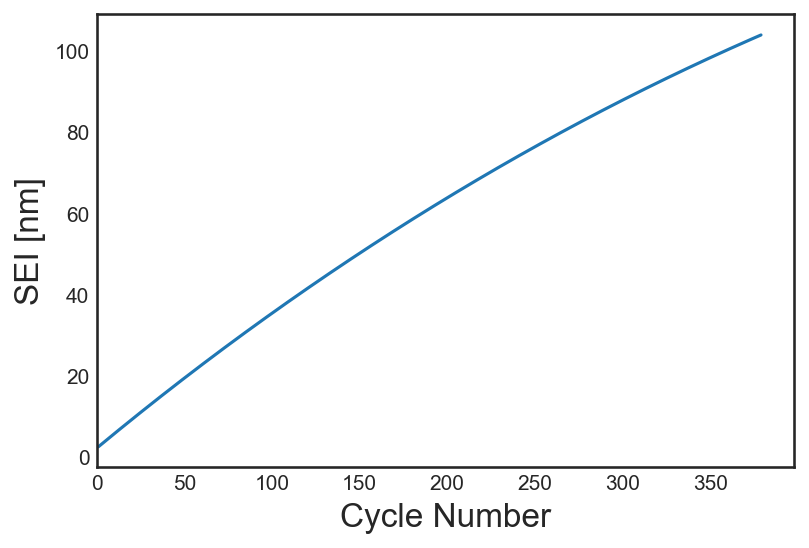

In [16]:
plt.figure()
plt.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict["X-averaged SEI thickness [m]"]*1e9)
plt.xlim(left=0)
plt.xlabel('Cycle Number', fontsize=16)
plt.ylabel('SEI [nm]', fontsize=16)
plt.savefig(fig_DIR +'SEI_'+cell_no)

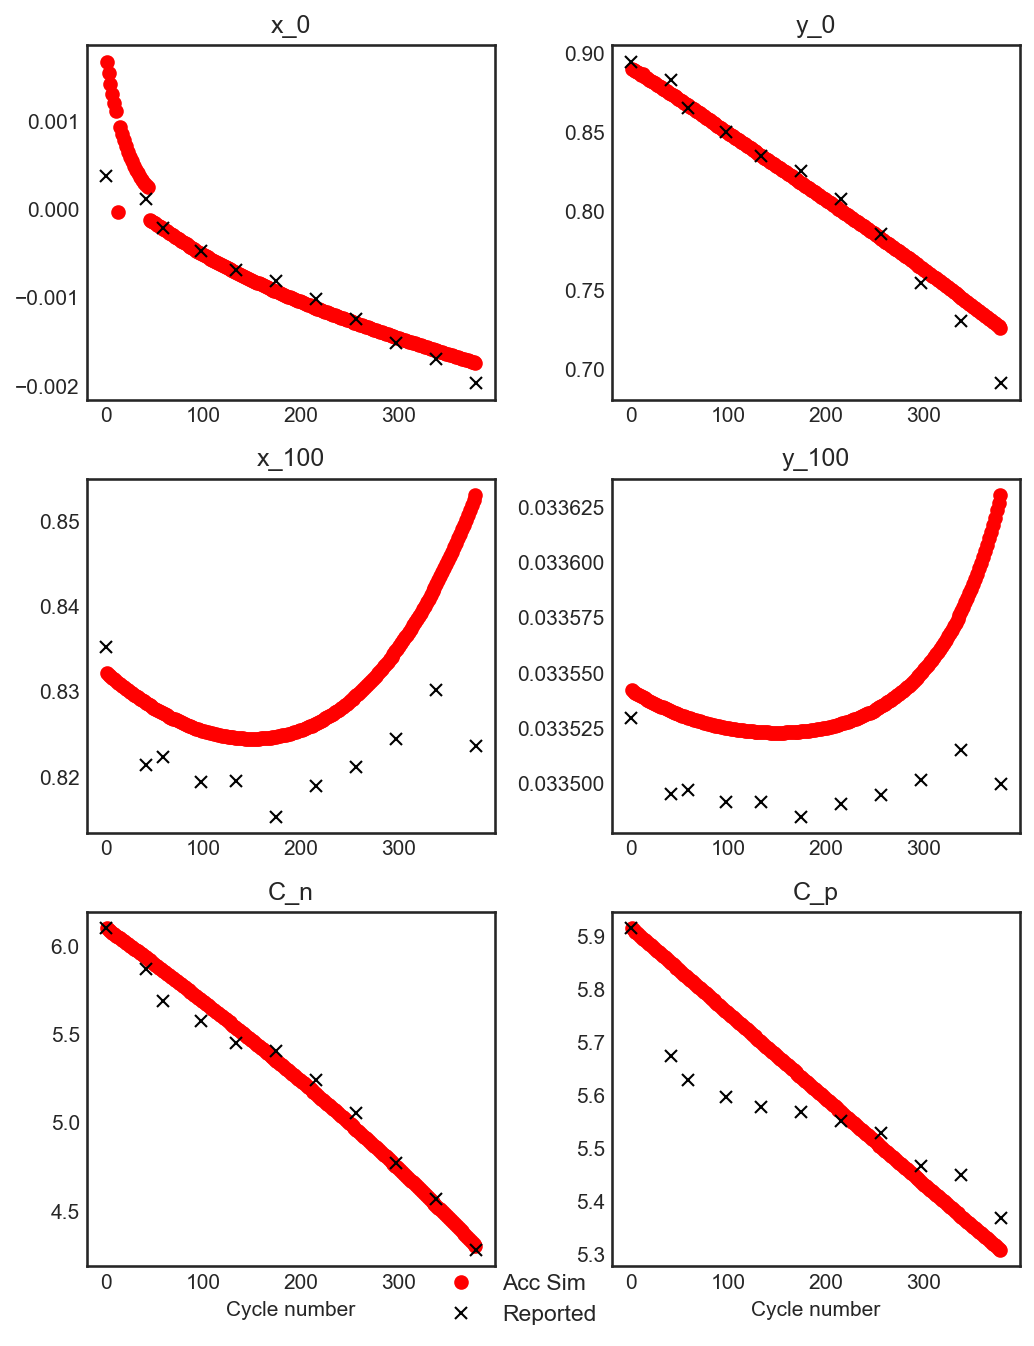

In [17]:
fig = plot(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

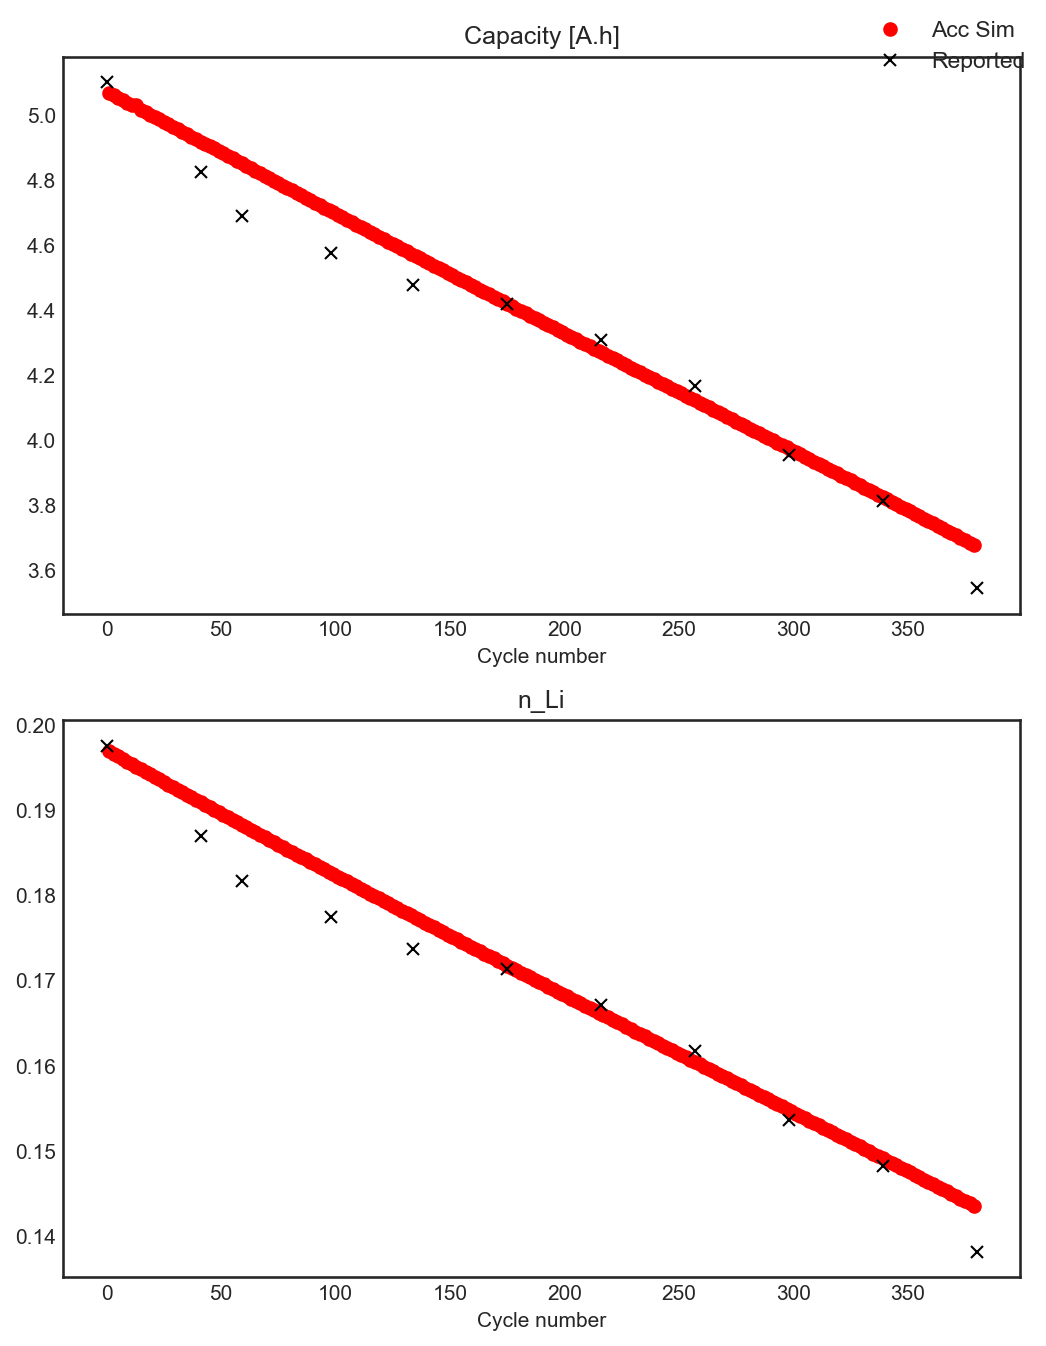

In [18]:
fig = plot1(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_cap_new.png')

In [19]:
def Up(sto):
    u_eq = (
        4.3452
        - 1.6518 * sto
        + 1.6225 * (sto ** 2)
        - 2.0843 * (sto ** 3)
        + 3.5146 * (sto ** 4)
        - 2.2166 * (sto ** 5)
        - 0.5623 * np.exp(109.451 * sto - 100.006)
    )
    return u_eq
def Un(sto):
    u_eq = (
        0.063
        + 0.8 * np.exp(-75 * (sto + 0.007))
        - 0.0120 * np.tanh((sto - 0.127) / 0.016)
        - 0.0118 * np.tanh((sto - 0.155) / 0.016)
        - 0.0035 * np.tanh((sto - 0.220) / 0.020)
        - 0.0095 * np.tanh((sto - 0.190) / 0.013)
        - 0.0145 * np.tanh((sto - 0.490) / 0.020)
        - 0.0800 * np.tanh((sto - 1.030) / 0.055)
    )

    return u_eq

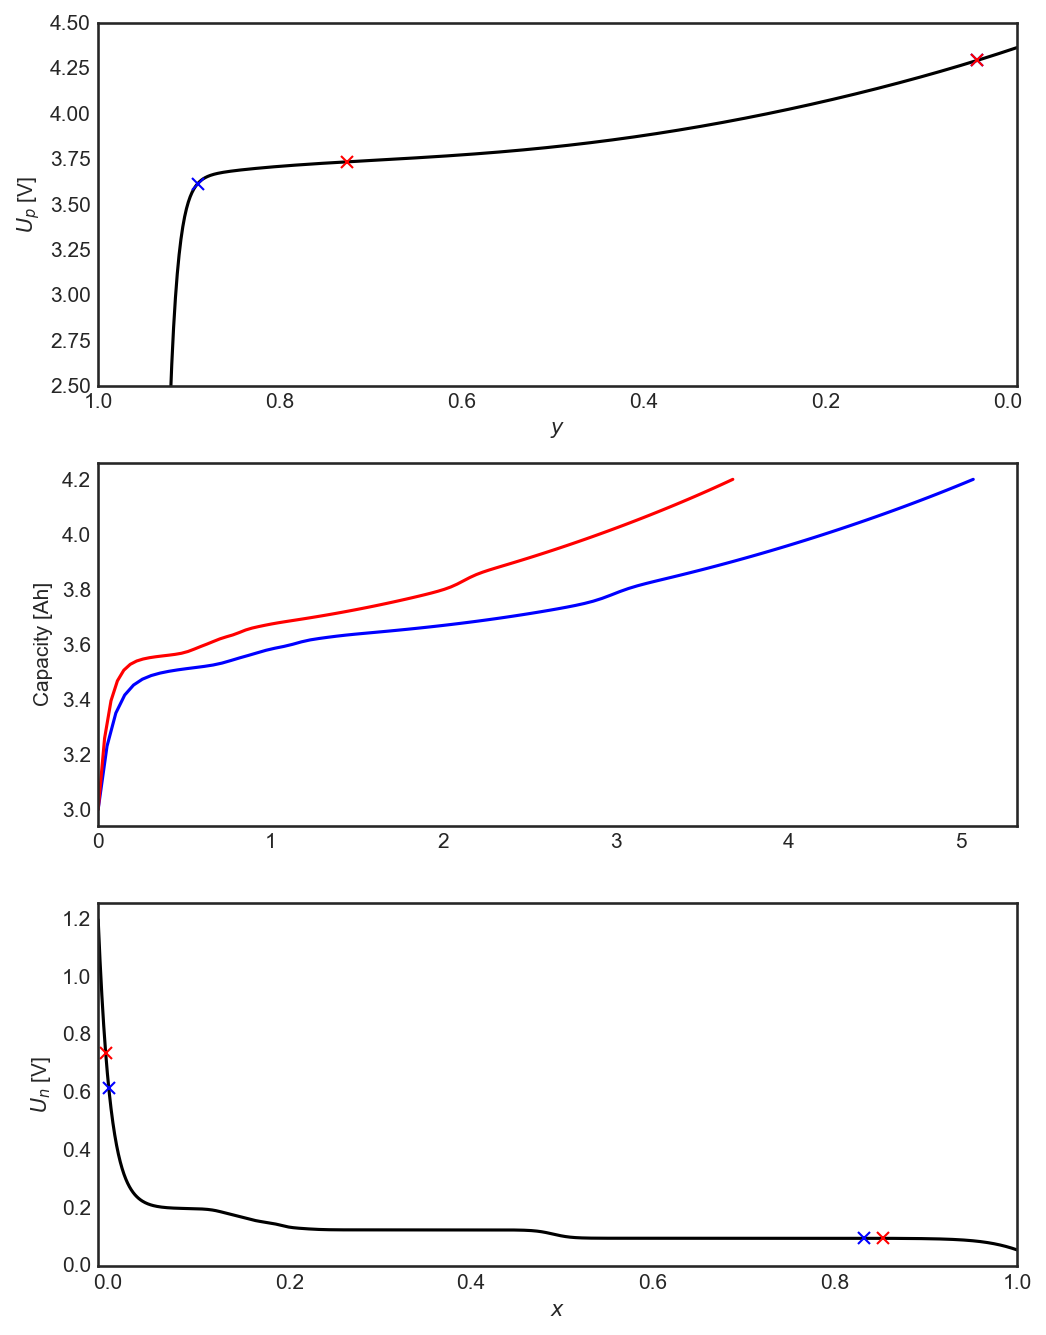

In [20]:
cyc_no = [0,-1]
x =np.linspace(-0.01,1,1000)
Upx = list(map(Up,x))
Unx = list(map(Un,x))

fig, axes = plt.subplots(3,1,figsize=(7,9))
ax1 = axes.flat[0]
ax1.plot(x,Upx,'k')
ax1.plot(all_sumvars_dict['y_0'][cyc_no[0]],Up(all_sumvars_dict['y_0'][cyc_no[0]]),'bx')
ax1.plot(all_sumvars_dict['y_0'][cyc_no[1]],Up(all_sumvars_dict['y_0'][cyc_no[1]]),'rx')
ax1.plot(all_sumvars_dict['y_100'][cyc_no[0]],Up(all_sumvars_dict['y_100'][cyc_no[0]]),'bx')
ax1.plot(all_sumvars_dict['y_100'][cyc_no[1]],Up(all_sumvars_dict['y_100'][cyc_no[1]]),'rx')
# ax1.axvline(x=all_sumvars_dict['y_0'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
# ax1.axvline(x=all_sumvars_dict['y_100'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
ax1.set_xlim(1, -0.01)
ax1.set_ylim(2.5,4.5)
ax1.set_xlabel('$y$')
ax1.set_ylabel('$U_p$ [V]')
ax2 = axes.flat[1]
xf = np.linspace(all_sumvars_dict['x_0'][cyc_no[0]],all_sumvars_dict['x_100'][cyc_no[0]],100)
yf = np.linspace(all_sumvars_dict['y_100'][cyc_no[0]],all_sumvars_dict['y_0'][cyc_no[0]],100)
yf = yf[::-1]
ax2.plot(np.linspace(0,all_sumvars_dict['C'][cyc_no[0]],100),Up(yf)-Un(xf),'b')
xa = np.linspace(all_sumvars_dict['x_0'][cyc_no[1]],all_sumvars_dict['x_100'][cyc_no[1]],100)
ya = np.linspace(all_sumvars_dict['y_100'][cyc_no[1]],all_sumvars_dict['y_0'][cyc_no[1]],100)
ya = ya[::-1]
ax2.plot(np.linspace(0,all_sumvars_dict['C'][cyc_no[1]],100),Up(ya)-Un(xa),'r')
ax2.set_ylabel('OCV [V]')
ax2.set_ylabel('Capacity [Ah]')
ax2.set_xlim(left=0)
ax3 = axes.flat[2]
ax3.plot(x,Unx,'k')
ax3.plot(all_sumvars_dict['x_0'][cyc_no[0]],Un(all_sumvars_dict['x_0'][cyc_no[0]]),'bx')
ax3.plot(all_sumvars_dict['x_0'][cyc_no[1]],Un(all_sumvars_dict['x_0'][cyc_no[1]]),'rx')
ax3.plot(all_sumvars_dict['x_100'][cyc_no[0]],Un(all_sumvars_dict['x_100'][cyc_no[0]]),'bx')
ax3.plot(all_sumvars_dict['x_100'][cyc_no[1]],Un(all_sumvars_dict['x_100'][cyc_no[1]]),'rx')
ax3.set_xlim(-0.01, 1)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$U_n$ [V]')
# ax3.set_ylabel('Cycle number')
# plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(all_sumvars_dict['Cycle number'][cyc_no]))
plt.savefig(fig_DIR +'esoh_fresh_aged'+cell_no)
fig.tight_layout()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

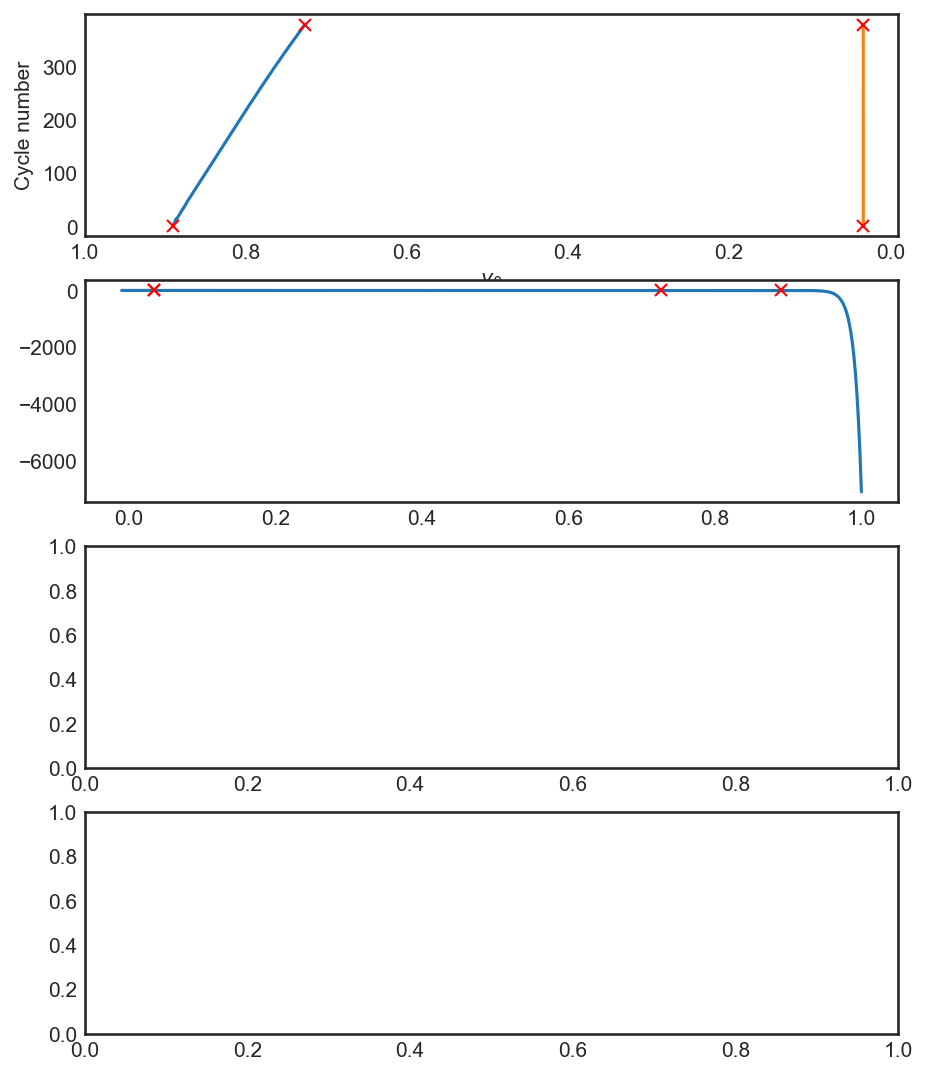

In [21]:
cyc_no = [0,-1]
x =np.linspace(-0.01,1,1000)
Upx = list(map(Up,x))
Unx = list(map(Un,x))

fig, axes = plt.subplots(4,1,figsize=(7,9))
ax1 = axes.flat[0]
ax1.plot(all_sumvars_dict['y_0'],all_sumvars_dict['Cycle number'])
ax1.plot(all_sumvars_dict['y_100'],all_sumvars_dict['Cycle number'])
ax1.plot(all_sumvars_dict['y_0'][cyc_no],all_sumvars_dict['Cycle number'][cyc_no],'rx')
ax1.plot(all_sumvars_dict['y_100'][cyc_no],all_sumvars_dict['Cycle number'][cyc_no],'rx')
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('Cycle number')
ax1.set_xlim(1, -0.01)
ax2 = axes.flat[1]
ax2.plot(x,Upx)
ax2.plot(all_sumvars_dict['y_0'][cyc_no],Up(all_sumvars_dict['y_0'][cyc_no]),'rx')
ax2.plot(all_sumvars_dict['y_100'][cyc_no],Up(all_sumvars_dict['y_100'][cyc_no]),'rx')
ax2.axvline(x=all_sumvars_dict['y_0'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
ax2.axvline(x=all_sumvars_dict['y_100'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
ax2.set_xlim(1, -0.01)
ax2.set_ylim(2.5,4.5)
ax2.set_xlabel('$y_0$')
ax2.set_ylabel('$U_p$')
ax3 = axes.flat[2]
ax3.plot(x,Unx)
ax3.plot(all_sumvars_dict['x_0'][cyc_no],Un(all_sumvars_dict['x_0'][cyc_no]),'rx')
ax3.plot(all_sumvars_dict['x_100'][cyc_no],Un(all_sumvars_dict['x_100'][cyc_no]),'rx')
ax3.set_xlim(-0.01, 1)
ax3.set_xlabel('$x_0$')
ax3.set_ylabel('$U_n$')
ax4 = axes.flat[3]
ax4.plot(all_sumvars_dict['x_0'],all_sumvars_dict['Cycle number'])
ax4.plot(all_sumvars_dict['x_100'],all_sumvars_dict['Cycle number'])
ax4.plot(all_sumvars_dict['x_0'][cyc_no],all_sumvars_dict['Cycle number'][cyc_no],'rx')
ax4.plot(all_sumvars_dict['x_100'][cyc_no],all_sumvars_dict['Cycle number'][cyc_no],'rx')
ax4.axvline(x=all_sumvars_dict['x_0'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
ax4.axvline(x=all_sumvars_dict['x_100'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
ax4.set_xlim(-0.01, 1)
ax4.set_xlabel('$x_0$')
ax4.set_ylabel('Cycle number')
plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(all_sumvars_dict['Cycle number'][cyc_no]))
plt.savefig(fig_DIR +'stoich_'+cell_no+'_cyc_'+str(all_sumvars_dict['Cycle number'][cyc_no]))
fig.tight_layout()

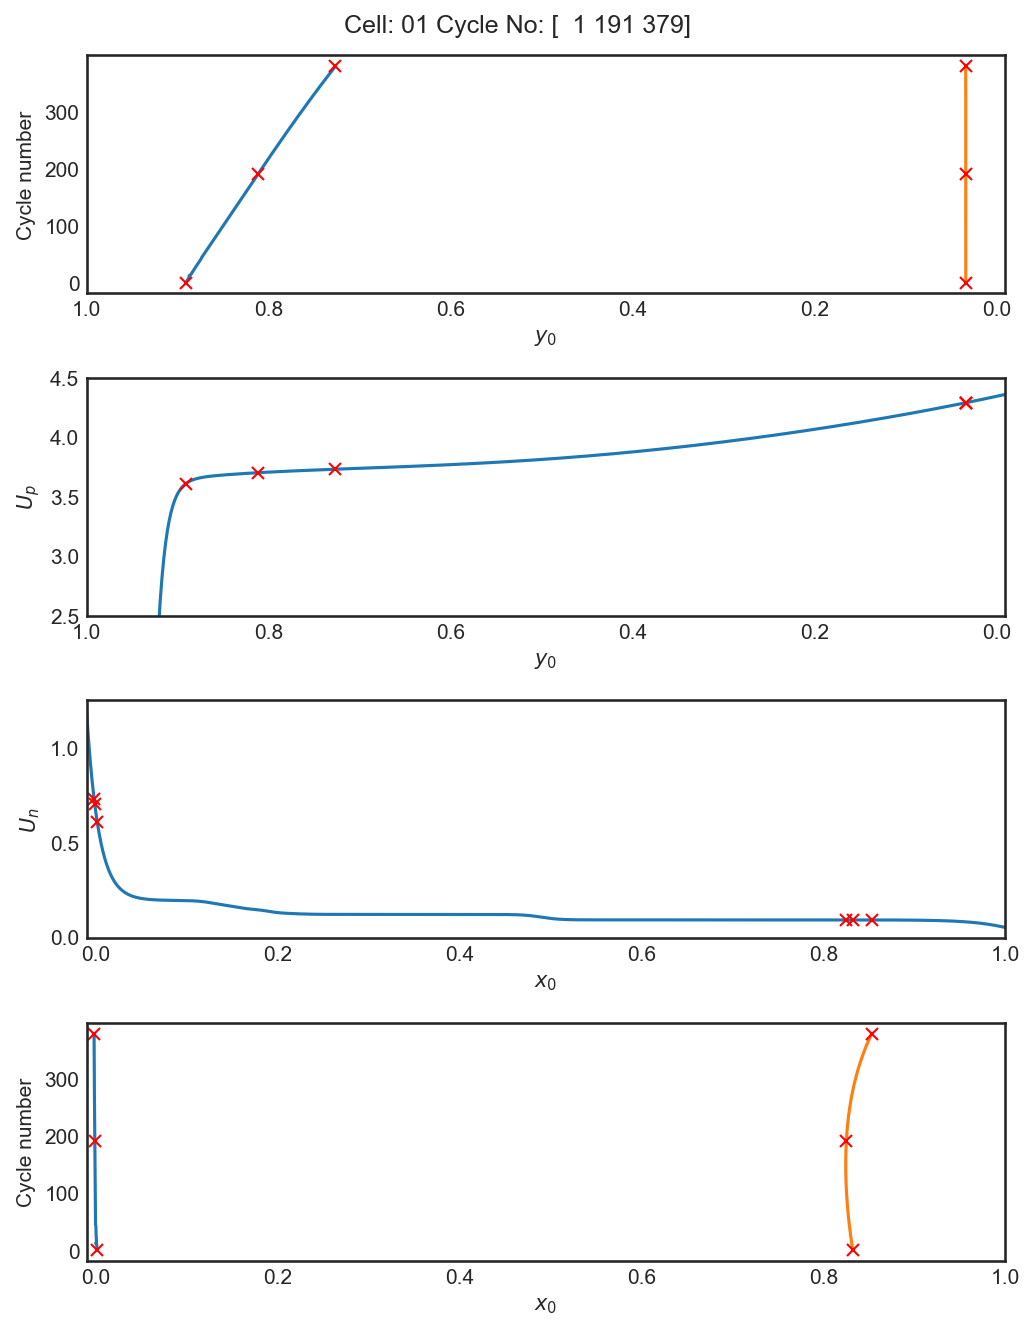

In [ ]:
cyc_no = [0,95,-1]
x =np.linspace(-0.01,1,1000)
Upx = list(map(Up,x))
Unx = list(map(Un,x))

fig, axes = plt.subplots(4,1,figsize=(7,9))
ax1 = axes.flat[0]
ax1.plot(all_sumvars_dict['y_0'],all_sumvars_dict['Cycle number'])
ax1.plot(all_sumvars_dict['y_100'],all_sumvars_dict['Cycle number'])
ax1.plot(all_sumvars_dict['y_0'][cyc_no],all_sumvars_dict['Cycle number'][cyc_no],'rx')
ax1.plot(all_sumvars_dict['y_100'][cyc_no],all_sumvars_dict['Cycle number'][cyc_no],'rx')
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('Cycle number')
ax1.set_xlim(1, -0.01)
ax2 = axes.flat[1]
ax2.plot(x,Upx)
ax2.plot(all_sumvars_dict['y_0'][cyc_no],Up(all_sumvars_dict['y_0'][cyc_no]),'rx')
ax2.plot(all_sumvars_dict['y_100'][cyc_no],Up(all_sumvars_dict['y_100'][cyc_no]),'rx')
# ax2.axvline(x=all_sumvars_dict['y_0'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
# ax2.axvline(x=all_sumvars_dict['y_100'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
ax2.set_xlim(1, -0.01)
ax2.set_ylim(2.5,4.5)
ax2.set_xlabel('$y_0$')
ax2.set_ylabel('$U_p$')
ax3 = axes.flat[2]
ax3.plot(x,Unx)
ax3.plot(all_sumvars_dict['x_0'][cyc_no],Un(all_sumvars_dict['x_0'][cyc_no]),'rx')
ax3.plot(all_sumvars_dict['x_100'][cyc_no],Un(all_sumvars_dict['x_100'][cyc_no]),'rx')
ax3.set_xlim(-0.01, 1)
ax3.set_xlabel('$x_0$')
ax3.set_ylabel('$U_n$')
ax4 = axes.flat[3]
ax4.plot(all_sumvars_dict['x_0'],all_sumvars_dict['Cycle number'])
ax4.plot(all_sumvars_dict['x_100'],all_sumvars_dict['Cycle number'])
ax4.plot(all_sumvars_dict['x_0'][cyc_no],all_sumvars_dict['Cycle number'][cyc_no],'rx')
ax4.plot(all_sumvars_dict['x_100'][cyc_no],all_sumvars_dict['Cycle number'][cyc_no],'rx')
# ax4.axvline(x=all_sumvars_dict['x_0'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
# ax4.axvline(x=all_sumvars_dict['x_100'][cyc_no],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=2.3)
ax4.set_xlim(-0.01, 1)
ax4.set_xlabel('$x_0$')
ax4.set_ylabel('Cycle number')
plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(all_sumvars_dict['Cycle number'][cyc_no]))
fig.tight_layout()
plt.savefig(fig_DIR +'stoich_'+cell_no+'_cyc_'+str(all_sumvars_dict['Cycle number'][cyc_no]))


In [22]:
# afsdfsd

In [23]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=1)

In [24]:
t = sol_long["Time [min]"].entries
sei =  sol_long["X-averaged SEI thickness [m]"].entries


In [25]:
sei[-1]

1.0425371897341964e-07

Text(0, 0.5, 'SEI [nm]')

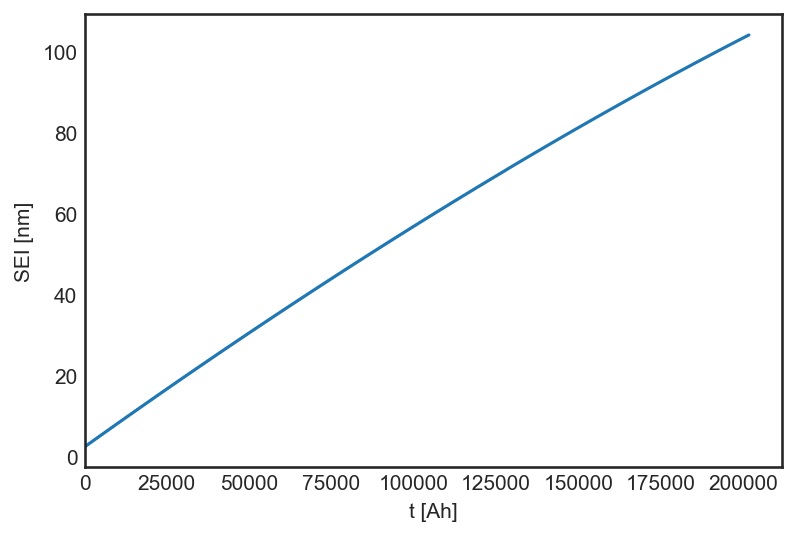

In [26]:
plt.figure()
plt.plot(t,sei*1e9)
plt.xlim(left=0)
plt.xlabel('t [Ah]')
plt.ylabel('SEI [nm]')

In [27]:
long_sol_output =sol_long.summary_variables

In [28]:
Ns = N
Ns[0] = 0
Ns = np.array(Ns)
# print(long_sol_output['Cycle number'][Ns])
print(Ns)


[  0  41  59  98 134 175 216 257 298 339 380]


In [29]:
Ns = np.insert(N[1:]-1,0,0)
print(Ns)
print(N)

[  0  40  58  97 133 174 215 256 297 338 379]
[  0  41  59  98 134 175 216 257 298 339 380]


In [30]:
long_sol_output['Cycle number'][Ns]

array([  1,  41,  59,  98, 134, 175, 216, 257, 298, 339, 380])

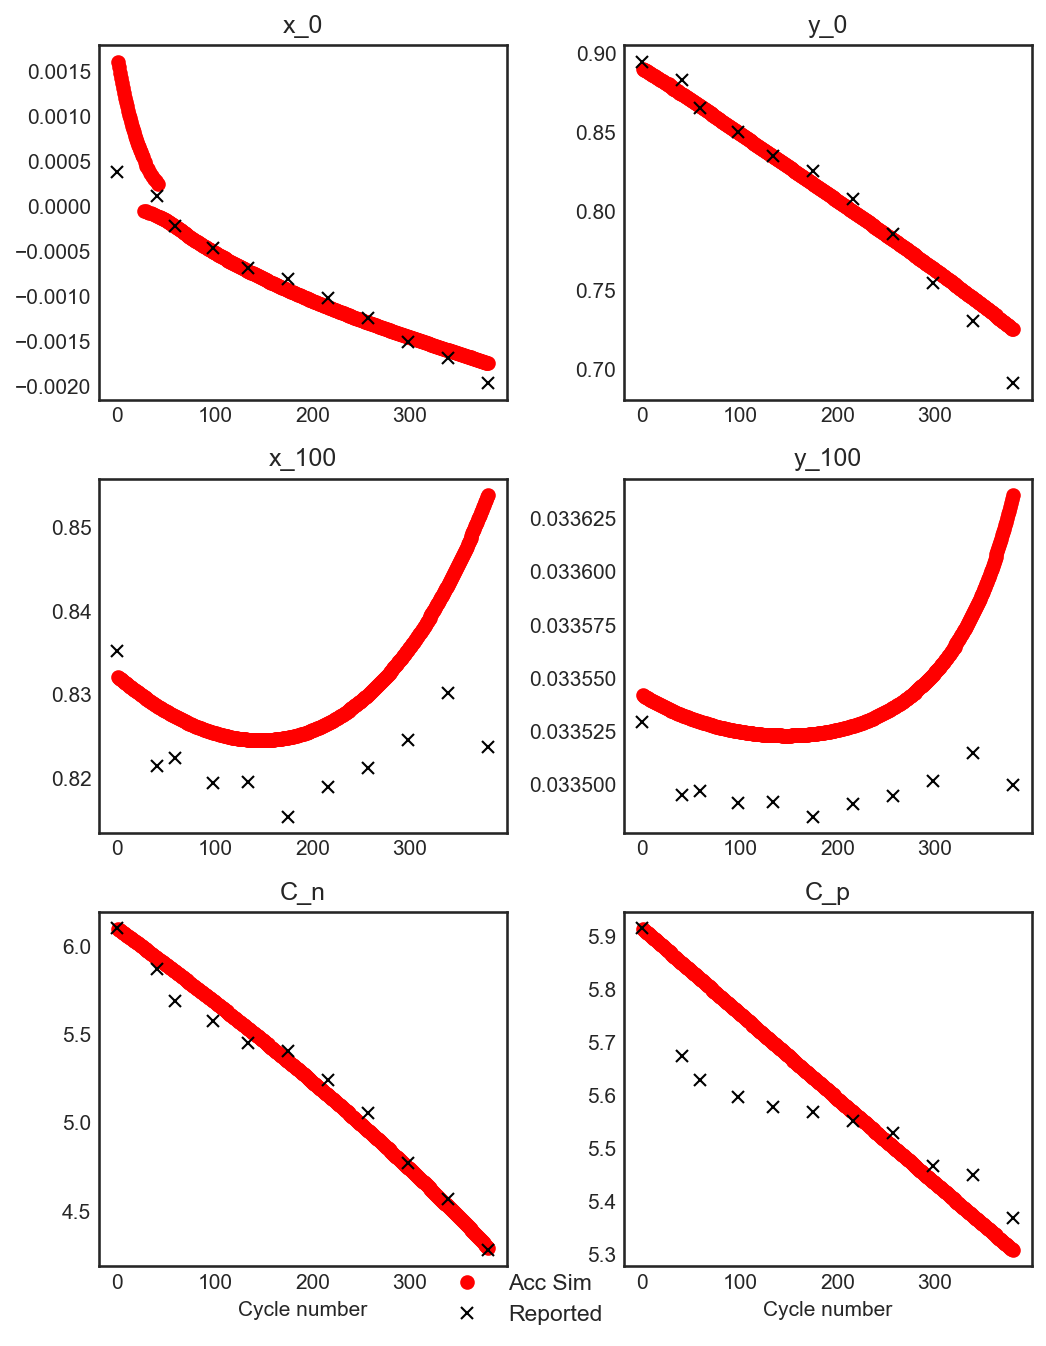

In [31]:
fig = plot(long_sol_output,dfe);

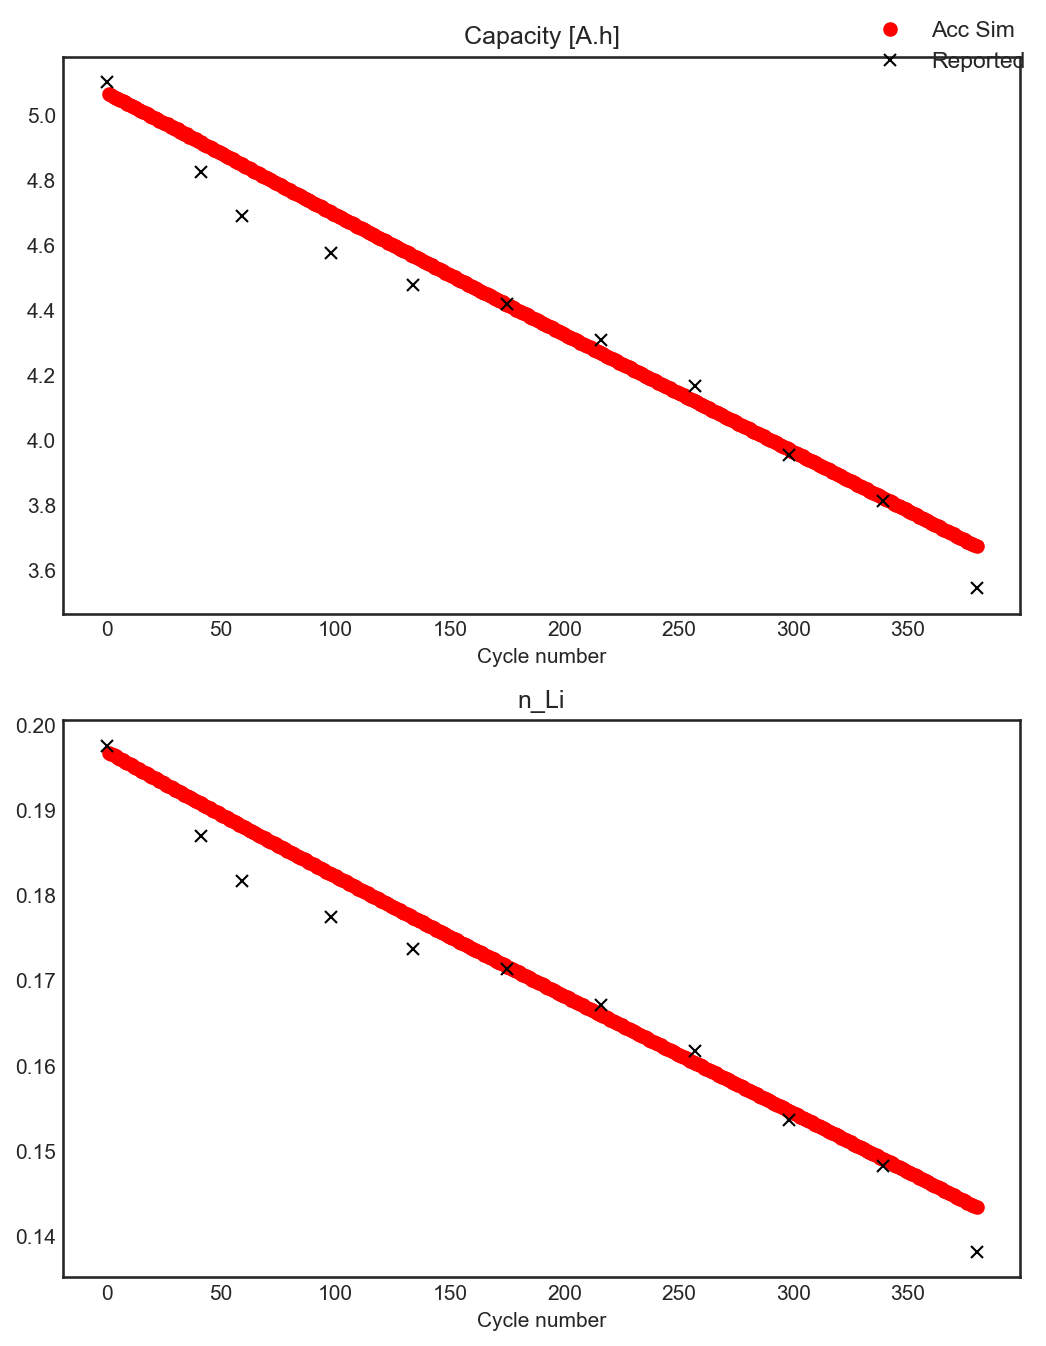

In [32]:
fig = plot1(long_sol_output,dfe);

In [33]:
# t = sol_long["Time [min]"].entries
# exp = sol_long["Cell thickness change [m]"].entries
# plt.figure()
# plt.plot(t,exp,'k')
# plt.xlim(left=0)
# plt.xlabel('Time [min]')
# plt.ylabel('Expansion [m]')

In [34]:
first_states = sol_long.all_first_states
summary_states = sol_long.all_summary_variables

In [35]:
len(first_states)
len(summary_states)

380

In [36]:
first_states[1]

In [37]:
dis_set = " until 3V"
c_rate_d = 'C/20'
c_rate_c = 'C/20'
experiment = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)

In [38]:
spm.set_initial_conditions_from(first_states[1])
sim_exp = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_exp = sim_exp.solve()

In [39]:
t_t = sol_exp["Time [min]"].entries
I_t = sol_exp["Current [A]"].entries
Q_t = -sol_exp['Discharge capacity [A.h]'].entries
Vt_t = sol_exp["Terminal voltage [V]"].entries
exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries

In [40]:
sei_t =  sol_exp["X-averaged SEI thickness [m]"].entries
len(sei_t)

2482

In [41]:
idx = np.where(np.diff(np.sign(I_t)))[0]
I = I_t[idx[-1]:]
t = t_t[idx[-1]:]-t_t[idx[-1]]
Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
Vt = Vt_t[idx[-1]:]
exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
sei = sei_t[idx[-1]:]

Text(0, 0.5, 'Voltage [V]')

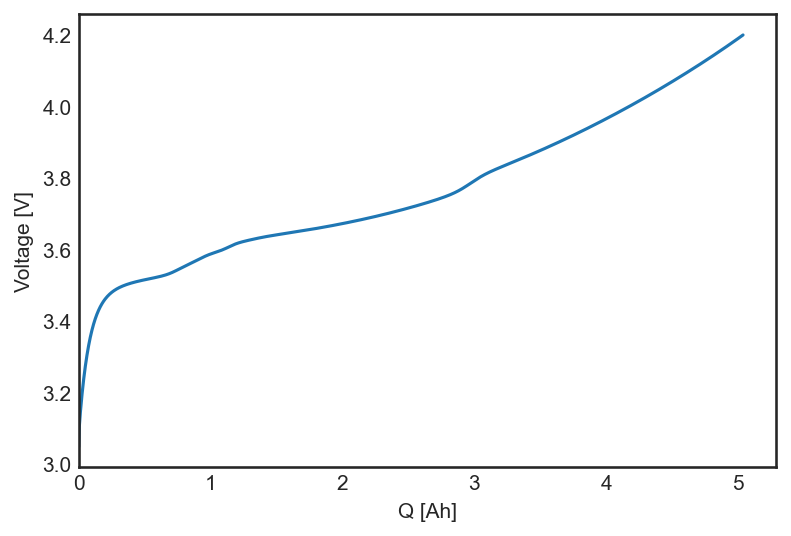

In [42]:
plt.figure()
plt.plot(Q,Vt)
plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Voltage [V]')

Text(0, 0.5, 'Expansion [m]')

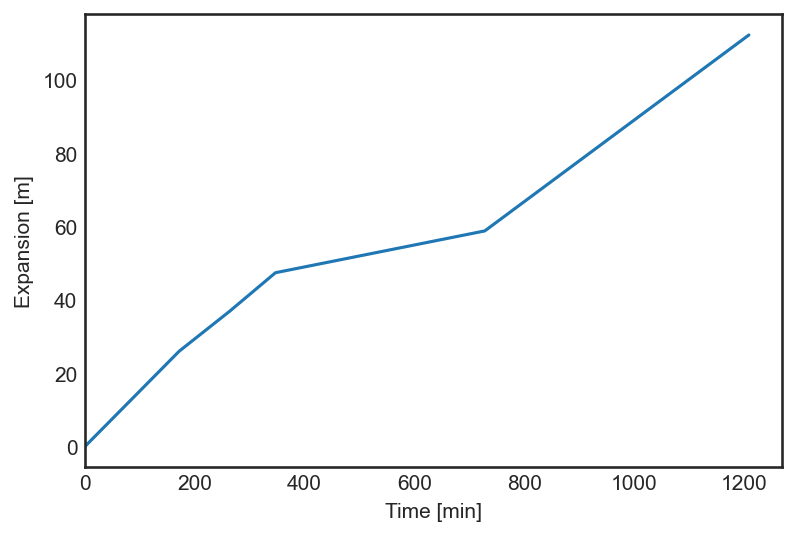

In [43]:
plt.figure()
plt.plot(t,exp)
plt.xlim(left=0)
plt.xlabel('Time [min]')
plt.ylabel('Expansion [m]')

In [44]:
def diff_analysis(cyc_no):
    dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    spm.set_initial_conditions_from(first_states[Ns[cyc_no]])
    sim_exp = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                                solver=pybamm.CasadiSolver("safe"))
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    sei = sei_t[idx[-1]:]
    window_length=501
    polyorder=5
    Qf_d = savgol_filter(dfo['Q'],window_length,polyorder)
    dQ_d = savgol_filter(dfo['Q'],window_length,polyorder,1)
    Vf_d = savgol_filter(dfo['V'],window_length,polyorder)
    dV_d = savgol_filter(dfo['V'],window_length,polyorder,1)
    window_length=1701
    polyorder=3
    Ef_d = savgol_filter(dfo['E']-dfo['E'].iloc[0],window_length,polyorder)
    dE2_d = savgol_filter(Ef_d,window_length,polyorder,2)
    window_length=51
    polyorder=5
    Qf_s = savgol_filter(Q,window_length,polyorder)
    dQ_s = savgol_filter(Q,window_length,polyorder,1)
    Vf_s = savgol_filter(Vt,window_length,polyorder)
    dV_s = savgol_filter(Vt,window_length,polyorder,1)
    window_length=301
    polyorder=3
    Ef_s = savgol_filter(exp,window_length,polyorder)
    dE2_s = savgol_filter(exp,window_length,polyorder,2)
    dE2_s = savgol_filter(Ef_s,window_length,polyorder,2)


    Q_filt = ((Q/max(Q))>0.15)
    int_V = interpolate.CubicSpline(Qf_d,Vf_d,extrapolate=True)
    rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    V_err = Vt*Q_filt-int_V(Q)*Q_filt
    V_max_loc = np.argmax(abs(V_err))
    V_err_Q = Q[V_max_loc]
    V_err_max = V_err[V_max_loc]
    if max(Q)<max(dfo['Q']):
        int_E = interpolate.CubicSpline(dfo['Q'],dfo['E']-dfo['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(dfo['E']-dfo['E'].iloc[0],int_E(dfo['Q']))
        E_err = int_E(dfo['Q'])-dfo['E']+dfo['E'].iloc[0]
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = dfo['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = dfo['Q']
    dVdQ_d = dV_d/dQ_d
    dVdQf_d = dVdQ_d*(dVdQ_d>0.16)
    dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_d = dV_peaks_d[-2:]
    dVdQ_s = dV_s/dQ_s
    dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
    dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_s = dV_peaks_s[-2:]  

    dQdV_d = dQ_d/dV_d
    dQdV_s = dQ_s/dV_s

    dEdQ2_d = dE2_d/dQ_d/dQ_d
    dEdQ2_s = dE2_s/dQ_s/dQ_s

    dEdQf2_d = dEdQ2_d*(dEdQ2_d>10)
    dE_peaks_d,_ = find_peaks(dEdQf2_d,height=0.1,width=0.1,prominence=0.2)
    dEdQf2_s = dEdQ2_s*(dEdQ2_s>10)
    dE_peaks_s,_ = find_peaks(dEdQf2_s,height=0.1,width=0.1,prominence=0.2)
    loc_d = np.where(np.diff(np.sign(dEdQ2_d[0:dE_peaks_d[0]])))[0]
    dE_zero_d = loc_d[-1]
    loc_s = np.where(np.diff(np.sign(dEdQ2_s[0:dE_peaks_s[0]])))[0]
    dE_zero_s = loc_s[-1]


    dQdVf_d = dQdV_d*(dQdV_d>8)
    dQ_peaks_d,_ = find_peaks(dQdVf_d,height=0.1,width=0.1,prominence=0.2)
    dQdVf_s = dQdV_s*(dQdV_s>8)
    dQ_peaks_s,_ = find_peaks(dQdVf_s,height=0.1,width=0.1,prominence=0.2)



    plt.figure(figsize=[10,8])
    ax1 =plt.subplot(3,2,1)
    ax1.plot(Qf_d,Vf_d,'k')
    ax1.plot(Q,Vt,'r--')
    ax1.legend(['Data' , 'Sim'])
    ax1.text(0.3,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('Terminal Voltage [V]')
    ax1.set_title('V')
    ax1.set_xlim(left=0)
    ax11 = ax1.twinx()
    ax11.plot(Q,V_err,'b--')
    ax11.plot(V_err_Q,V_err_max,'mx')
    ax11.text(V_err_Q,V_err_max,f'max err: {V_err_max*1e3:0.1f} mV')
    ax11.set_ylabel('Residual [V]')
    ax2 = plt.subplot(3,2,2)
    ax2.plot(Qf_d,dVdQ_d,'k')
    ax2.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'mx')
    ax2.plot(Qf_s,dVdQ_s,'r--')
    ax2.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
    peak1_err = (Qf_s[dV_peaks_s[0]]/Qf_s[-1])-(Qf_d[dV_peaks_d[0]]/Qf_d[-1])
    ax2.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.4f}',transform=ax2.transAxes)
    peak2_err = (Qf_s[dV_peaks_s[1]]/Qf_s[-1])-(Qf_d[dV_peaks_d[1]]/Qf_d[-1])
    ax2.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.4f}',transform=ax2.transAxes)
    ax2.set_title('dVdQ')
    ax2.set_ylabel('Differential Voltage [V/Ah]')
    ax2.set_ylim([0,0.5])
    ax2.set_xlim(left=0)
    ax3 = plt.subplot(3,2,3)
    ax3.plot(dfo['Q'], dfo['E']-dfo['E'].iloc[0],'k')
    ax3.plot(Q,exp,'r--')
    ax3.text(0.3,0.2,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax3.transAxes)
    ax3.set_xlim(left=0)
    ax3.set_xlabel('Q [Ah]')
    ax3.set_ylabel('Electrode Expansion [$\mu$m]')
    ax3.set_title('$\Delta$t')
    ax31 = ax3.twinx()
    ax31.plot(Q_err,E_err,'b--')
    ax31.plot(E_err_Q,E_err_max,'mx')
    ax31.text(E_err_Q,E_err_max,f'max err: {E_err_max:0.1f} $\mu$m')
    ax31.set_ylabel('Residual [$\mu$m]')
    ax4 = plt.subplot(3,2,4)
    ax4.plot(Qf_d,dQdV_d,'k')
    ax4.plot(Qf_s,dQdV_s,'r--')
    ax4.plot(Qf_d[dQ_peaks_d[-1]],dQdV_d[dQ_peaks_d[-1]],'mx')
    ax4.plot(Qf_s[dQ_peaks_s[-1]],dQdV_s[dQ_peaks_s[-1]],'bx')
    peakQ_err = (Qf_s[dQ_peaks_s[-1]]/Qf_s[-1])-(Qf_d[dQ_peaks_d[-1]]/Qf_d[-1])
    ax4.text(0.6,0.8,f'Peak Err: {peakQ_err:0.4f}',transform=ax4.transAxes)
    ax4.set_xlabel('Q [Ah]')
    ax4.set_ylabel('Incremental Capacity [Ah/V]')
    ax5 = plt.subplot(3,2,6)
    ax5.plot(Qf_d,dEdQ2_d,'k')
    ax5.plot(Qf_s,dEdQ2_s,'r--')
    ax5.plot(Qf_d[dE_peaks_d],dEdQ2_d[dE_peaks_d],'mx')
    ax5.plot(Qf_s[dE_peaks_s],dEdQ2_s[dE_peaks_s],'bx')
    peakE_err = (Qf_s[dE_peaks_s]/Qf_s[-1])-(Qf_d[dE_peaks_d]/Qf_d[-1])
    ax5.text(0.7,0.8,f'Peak Err: {peakE_err[0]:0.4f}',transform=ax5.transAxes)
    ax5.plot(Qf_d[dE_zero_d],dEdQ2_d[dE_zero_d],'x')
    ax5.plot(Qf_s[dE_zero_s],dEdQ2_s[dE_zero_s],'x')
    peakZ_err = (Qf_s[dE_zero_s]/Qf_s[-1])-(Qf_d[dE_zero_d]/Qf_d[-1])
    ax5.text(0.4,0.3,f'Peak Err: {peakZ_err:0.4f}',transform=ax5.transAxes)
    ax5.set_xlabel('Q [Ah]')
    ax5.set_ylabel('Differential Expansion [$\mu m/Ah^2$]')
    ax1.set_xlim([0,5])
    ax2.set_xlim([0,5])
    ax3.set_xlim([0,5])
    ax4.set_xlim([0,5])
    ax5.set_xlim([0,5])
    ax5.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_d[dQ_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_s[dQ_peaks_s[-1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_d[dE_peaks_d],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_s[dE_peaks_s],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_d[dE_zero_d],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    ax5.axvline(x=Qf_s[dE_zero_s],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=3.5)
    plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(N[cyc_no]))
    plt.tight_layout()
    plt.savefig(fig_DIR +'deg_sim_'+cell_no+'_cyc_'+str(N[cyc_no]))
    return plt,rmse_V,rmse_E,peak1_err,peak2_err,peakQ_err,peakE_err,peakZ_err


In [45]:
type(N)

numpy.ndarray

In [46]:
rmse_V_l = []
rmse_E_l = []
peak1_error_l = []
peak2_error_l = []
peakQ_error_l = []
peakE_error_l = []
peakZ_error_l = []
mask = np.ones(len(N), dtype=bool)
for cyc_no in range(len(N)):
    print(cyc_no)
    try:
        plt,rmse_V,rmse_E,peak1_err,peak2_err,peakQ_err,peakE_err,peakZ_err = diff_analysis(cyc_no)
        plt.close()
        rmse_V_l = np.append(rmse_V_l,rmse_V)
        rmse_E_l = np.append(rmse_E_l,rmse_E)
        peak1_error_l = np.append(peak1_error_l,peak1_err)
        peak2_error_l = np.append(peak2_error_l,peak2_err)
        peakZ_error_l = np.append(peakZ_error_l,peakZ_err)
        peakE_error_l = np.append(peakE_error_l,peakE_err)
        peakQ_error_l = np.append(peakQ_error_l,peakQ_err)
        mask[cyc_no] = True
    except:
        mask[cyc_no] = False
N_mod = N[mask]

0
1
2
3
4
5
6
7
8
9
10


In [47]:
df_error = pd.DataFrame(
    {'Cycle No':N_mod, 'RMSE V':rmse_V_l*1000,'RMSE E':rmse_E_l,
    'dVdQ_P1 Err':peak1_error_l,'dVdQ_P2 Err':peak2_error_l,
    'dQdV_P Err':peakQ_error_l,
    'dEdQ_Z Err':peakZ_error_l,'dEdQ_E Err':peakE_error_l
    }
)
df_error

,Cycle No,RMSE V,RMSE E,dVdQ_P1 Err,dVdQ_P2 Err,dQdV_P Err,dEdQ_Z Err,dEdQ_E Err
0,0,7.488873,2.355999,0.003755,-0.000058,0.019213,0.013867,-0.006342
1,41,8.132950,3.600155,0.005985,-0.006751,0.017222,0.008069,-0.004629
2,59,17.710060,2.195495,0.009661,-0.005076,-0.006706,0.011716,-0.006067
3,98,13.462029,2.450317,0.007861,-0.006560,0.017144,0.015738,-0.007462
4,134,9.259284,2.552770,0.006009,-0.007291,0.016811,0.011207,-0.010761
5,175,5.782024,2.321207,0.006008,-0.003709,0.009559,0.008972,0.000132
6,216,9.701595,3.321251,0.006162,-0.002449,0.010192,0.011277,-0.000820
7,257,9.830016,3.967635,0.007332,-0.001012,0.008995,0.017242,-0.000966
8,298,3.235989,5.085848,0.010066,0.000556,0.013069,-0.003152,-0.006321
9,339,3.038040,4.215841,0.051716,0.005885,0.009365,0.009178,-0.001421


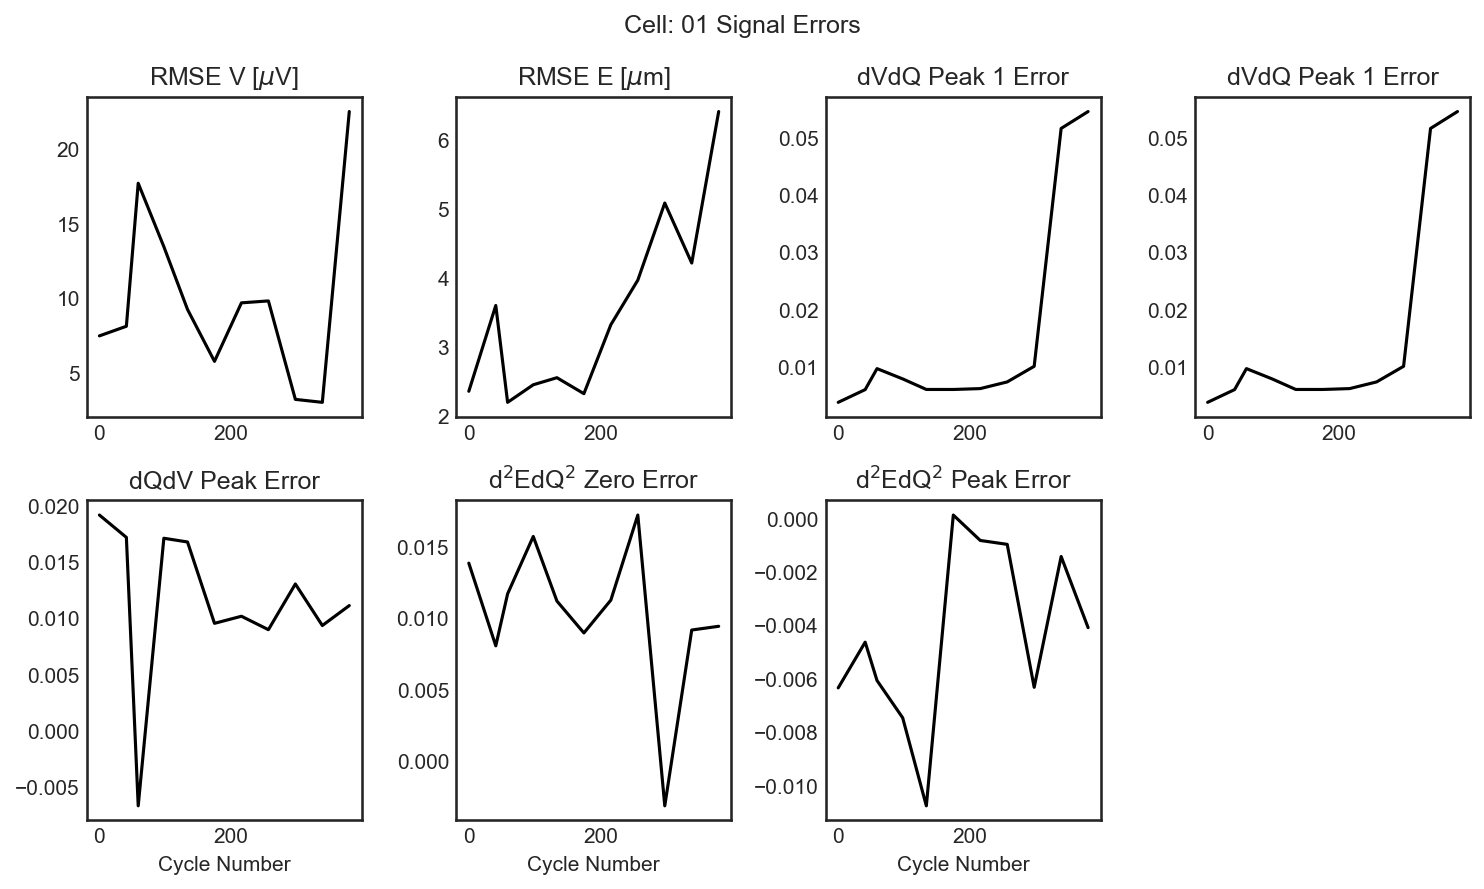

In [48]:
plt.figure(figsize=[10,6])
ax1 =plt.subplot(2,4,1)
ax1.plot(df_error['Cycle No'],df_error['RMSE V'],'k')
ax1.set_title('RMSE V [$\mu$V]')
ax2 =plt.subplot(2,4,2)
ax2.plot(df_error['Cycle No'],df_error['RMSE E'],'k')
ax2.set_title('RMSE E [$\mu$m]')
ax3 =plt.subplot(2,4,3)
ax3.plot(df_error['Cycle No'],df_error['dVdQ_P1 Err'],'k')
ax3.set_title('dVdQ Peak 1 Error')
ax4 =plt.subplot(2,4,4)
ax4.plot(df_error['Cycle No'],df_error['dVdQ_P1 Err'],'k')
ax4.set_title('dVdQ Peak 1 Error')
ax5 =plt.subplot(2,4,5)
ax5.plot(df_error['Cycle No'],df_error['dQdV_P Err'],'k')
ax5.set_title('dQdV Peak Error')
ax5.set_xlabel('Cycle Number')
ax6 =plt.subplot(2,4,6)
ax6.plot(df_error['Cycle No'],df_error['dEdQ_Z Err'],'k')
ax6.set_title('d$^2$EdQ$^2$ Zero Error')
ax6.set_xlabel('Cycle Number')
ax7 =plt.subplot(2,4,7)
ax7.plot(df_error['Cycle No'],df_error['dEdQ_E Err'],'k')
ax7.set_title('d$^2$EdQ$^2$ Peak Error')
ax7.set_xlabel('Cycle Number')
plt.suptitle('Cell: '+cell_no+' Signal Errors')
plt.tight_layout()
plt.savefig(fig_DIR +'deg_sim_'+cell_no+'_error')

In [49]:
def plot_exp(cyc_no,plt,i):
    dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    spm.set_initial_conditions_from(first_states[Ns[cyc_no]])
    sim_exp = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                                solver=pybamm.CasadiSolver("safe"))
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    window_length=501
    polyorder=5
    Qf_d = savgol_filter(dfo['Q'],window_length,polyorder)
    Vf_d = savgol_filter(dfo['V'],window_length,polyorder)
    ax1 =plt.subplot(2,4,i)
    ax1.plot(Qf_d,Vf_d,'k')
    ax1.plot(Q,Vt,'r--')
    ax1.legend(['Data' , 'Sim'])
    # ax1.text(0.3,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    # ax1.annotate(xy=(Q[-1],Vt[-1]), text=f'{N[cyc_no]}', va='center')
    # ax1.set_xlim(left=0)
    ax1.set_xlim([0,5])
    ax1.set_ylim([3,4.2])
    ax2 = plt.subplot(2,4,i+4)
    ax2.plot(dfo['Q'], dfo['E']-dfo['E'].iloc[0],'k')
    ax2.plot(Q,exp,'r--')
    # ax2.text(0.3,0.2,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax3.transAxes)
    # ax2.annotate(xy=(Q[-1],exp[-1]), text=f'{N[cyc_no]}', va='center')
    # print(exp[-1])
    ax2.set_xlim([0,5])
    ax2.set_ylim([0,110])
    ax2.set_xlabel('Q [Ah]')
    ax1.set_title(' N='+f'{N[cyc_no]}')
    # ax2.set_title('$\Delta t$'+' N='+f'{N[cyc_no]}')
    if i==1:
        ax1.set_ylabel('V [V]',fontsize=16)
        ax2.set_ylabel('$\Delta$t [$\mu$m]',fontsize=16)
    return plt


0
3
6
10


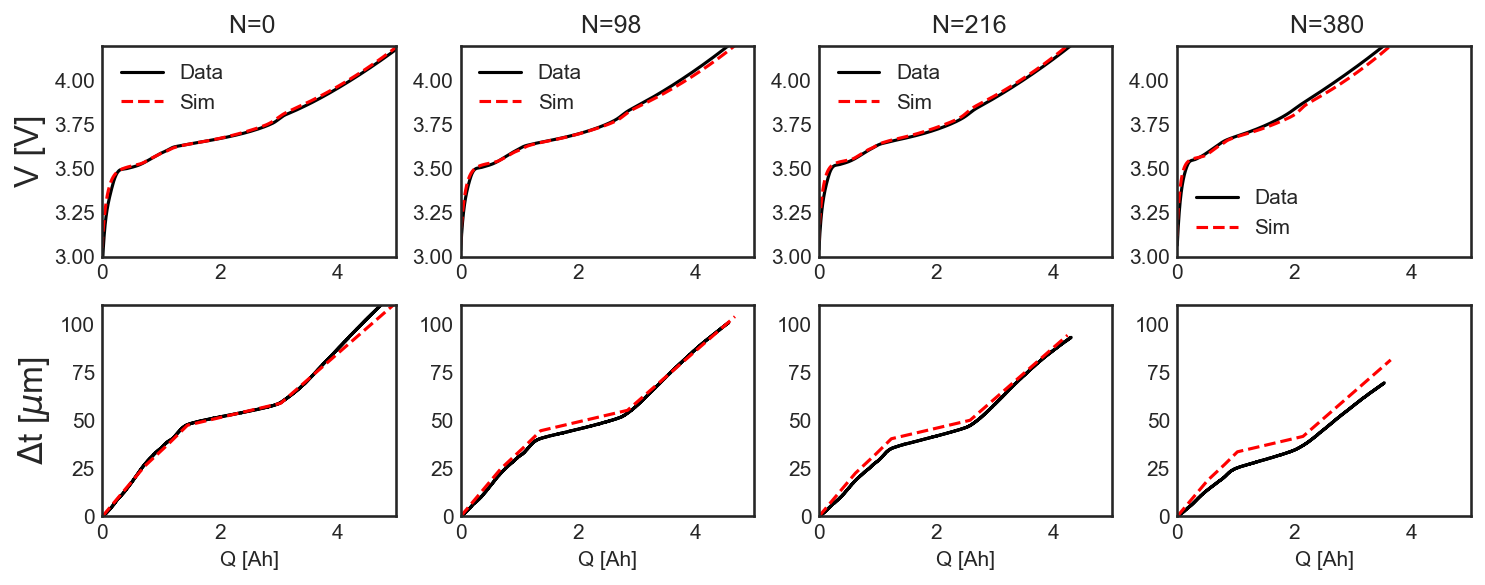

In [50]:
plt.figure(figsize=[10,4])
# for cyc_no in range(len(N)):
i = 1
for cyc_no in [0,3,6,10]:
# for cyc_no in [0,10]:
    print(cyc_no)
    plt = plot_exp(cyc_no,plt,i)
    i+=1
plt.tight_layout()
plt.savefig(fig_DIR +'exp_plots_'+cell_no)

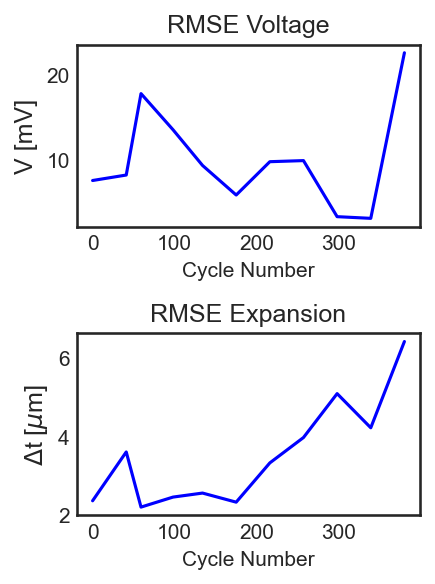

In [51]:
plt.figure(figsize=[3,4])
ax1 =plt.subplot(2,1,1)
ax1.plot(df_error['Cycle No'],df_error['RMSE V'],'b')
ax1.set_title('RMSE Voltage')
ax1.set_ylabel('V [mV]',fontsize=12)
ax1.set_xlabel('Cycle Number')
ax2 =plt.subplot(2,1,2)
ax2.plot(df_error['Cycle No'],df_error['RMSE E'],'b')
ax2.set_title('RMSE Expansion')
ax2.set_ylabel('$\Delta$t [$\mu$m]',fontsize=12)
ax2.set_xlabel('Cycle Number')
plt.tight_layout()
plt.savefig(fig_DIR +'deg_sim_'+cell_no+'_error_exp')

In [52]:
parameter_values.search("Stress")

Negative electrode critical stress [Pa]	60000000.0
Positive electrode critical stress [Pa]	375000000.0


In [53]:
def Up(sto):
    u_eq = (
        4.3452
        - 1.6518 * sto
        + 1.6225 * (sto ** 2)
        - 2.0843 * (sto ** 3)
        + 3.5146 * (sto ** 4)
        - 2.2166 * (sto ** 5)
        - 0.5623 * np.exp(109.451 * sto - 100.006)
    )
    return u_eq
def Un(sto):
    u_eq = (
        0.063
        + 0.8 * np.exp(-75 * (sto + 0.007))
        - 0.0120 * np.tanh((sto - 0.127) / 0.016)
        - 0.0118 * np.tanh((sto - 0.155) / 0.016)
        - 0.0035 * np.tanh((sto - 0.220) / 0.020)
        - 0.0095 * np.tanh((sto - 0.190) / 0.013)
        - 0.0145 * np.tanh((sto - 0.490) / 0.020)
        - 0.0800 * np.tanh((sto - 1.030) / 0.055)
    )

    return u_eq
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change(sto):
    a = 0.50
    b = 0.24
    c = 0.18 
    d = 0.12
    t_change = 0
    if sto < d:
        t_change = 2.4060/d*sto
    elif d <= sto and sto < c:
        t_change = -(2.4060-3.3568)/(c-d)*(sto-d)+2.4060
    elif c <= sto and sto < b:
        t_change = -(3.3568-4.3668)/(b-c)*(sto-c)+3.3568
    elif b <= sto and sto < a:
        t_change = -(4.3668-5.583)/(a-b)*(sto-b)+4.3668
    elif a <= sto:
        t_change = -(5.583-13.0635)/(1-a)*(sto-a)+5.583
    t_change = t_change/100
    return t_change

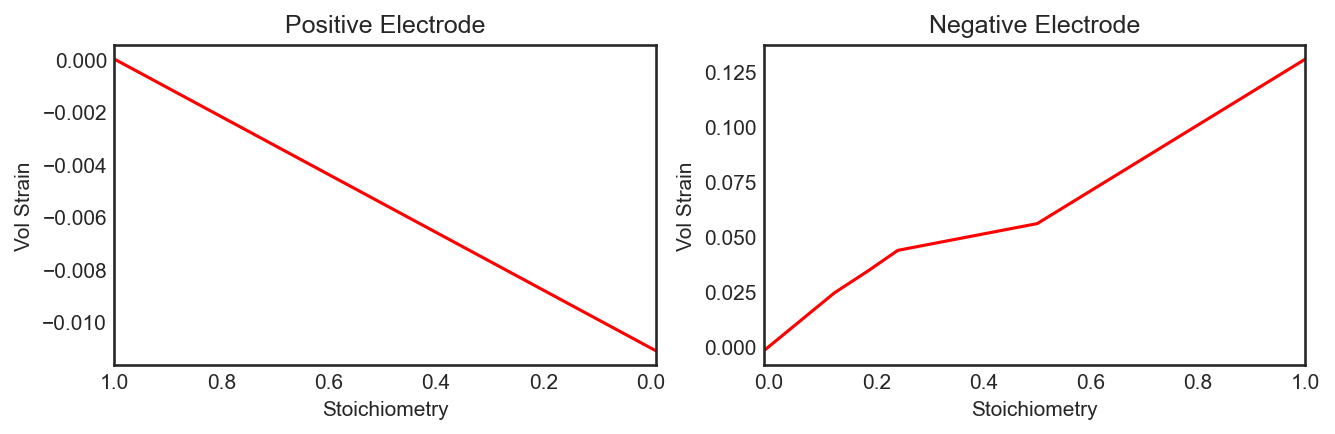

In [54]:
x =np.linspace(-0.01,1,1000)
Upx = list(map(Up,x))
Unx = list(map(Un,x))
Epx = list(map(nmc_volume_change_mohtat,x))
Enx = list(map(graphite_volume_change,x))
fig, axes = plt.subplots(1,2,figsize=(9,3))
ax1 = axes.flat[0]
# ax1.set_ylim(3,4.5)
ax1.set_xlim(1, -0.01)
ax1.plot(x,Epx,'r')
ax2 = axes.flat[1]
ax2.set_xlim(-0.01, 1)
ax2.plot(x,Enx,'r')
ax1.set_xlabel('Stoichiometry')
ax2.set_xlabel('Stoichiometry')
ax1.set_ylabel('Vol Strain')
ax1.set_title('Positive Electrode')
ax2.set_title('Negative Electrode')
# ax2.set_xlabel(r'Stoichiometry $\left(\frac{c_s}{c_{s,max}}\right)$')
# ax2.set_xlabel(r'Stoichiometry $\left(\frac{c_s}{c_{s,max}}\right)$')
ax2.set_ylabel('Vol Strain')
fig.tight_layout()
# fig.suptitle('Expansion Functions $(\Delta V)$')
plt.savefig(fig_DIR +'Expansion Functions')


## ACC Plots

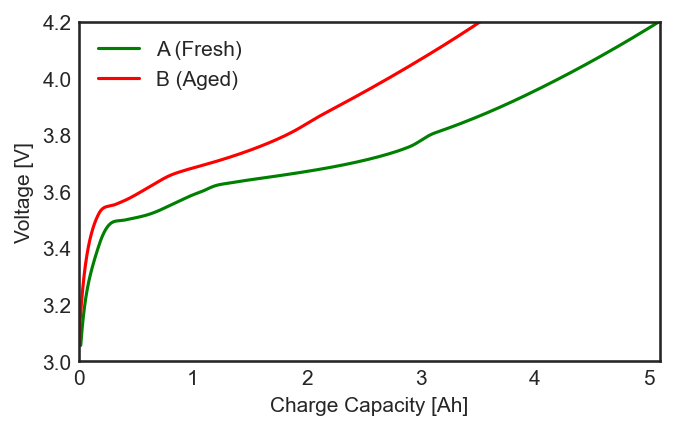

In [115]:
fig, ax1 = plt.subplots(1,1,figsize=(5,3))
dfo = dfo_0[dfo_0['N']==N[0]]
window_length=501
polyorder=5
Qf_d = savgol_filter(dfo['Q'],window_length,polyorder)
Vf_d = savgol_filter(dfo['V'],window_length,polyorder)
# ax1.plot(5.1-(Qf_d[-1]-Qf_d),Vf_d,'g')
ax1.plot(Qf_d[25:],Vf_d[25:],'g')
dfo = dfo_0[dfo_0['N']==N[-1]]
Qf_d = savgol_filter(dfo['Q'],window_length,polyorder)
Vf_d = savgol_filter(dfo['V'],window_length,polyorder)
ax1.plot(Qf_d,Vf_d,'r')
ax1.legend(['A (Fresh)','B (Aged)'])
ax1.set_ylabel('Voltage [V]')
ax1.set_xlabel('Charge Capacity [Ah]')
ax1.set_xlim([0,5.1])
ax1.set_ylim([3,4.2])
plt.savefig(fig_DIR +'ACC_voltage_lifetime'+'.png')

In [104]:
def plot_vol(cyc_no,plt,ax1,i):
    dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    spm.set_initial_conditions_from(first_states[Ns[cyc_no]])
    sim_exp = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                                solver=pybamm.CasadiSolver("safe"))
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    window_length=501
    polyorder=5
    Qf_d = savgol_filter(dfo['Q'],window_length,polyorder)
    Vf_d = savgol_filter(dfo['V'],window_length,polyorder)
    colors = ['green','orange','magenta']
    ax1.plot(Qf_d,Vf_d,color=colors[i-1])
    ax1.plot(Q,Vt,color=colors[i-1],linestyle='--',label='_nolegend_')
    # ax1.text(0.3,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    # ax1.annotate(xy=(Q[-1],Vt[-1]), text=f'{N[cyc_no]}', va='center')
    # ax1.set_xlim(left=0)
    ax1.set_xlim([0,5])
    ax1.set_ylim([3,4.2])
    # ax2.text(0.3,0.2,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax3.transAxes)
    # ax2.annotate(xy=(Q[-1],exp[-1]), text=f'{N[cyc_no]}', va='center')
    # print(exp[-1])
    # ax1.set_title(' N='+f'{N[cyc_no]}')
    # ax2.set_title('$\Delta t$'+' N='+f'{N[cyc_no]}')
    ax1.set_ylabel('V [V]',fontsize=16)
    ax1.set_xlabel('Charge Capacity [Ah]',fontsize=16)
    return plt,ax1


0
5
10


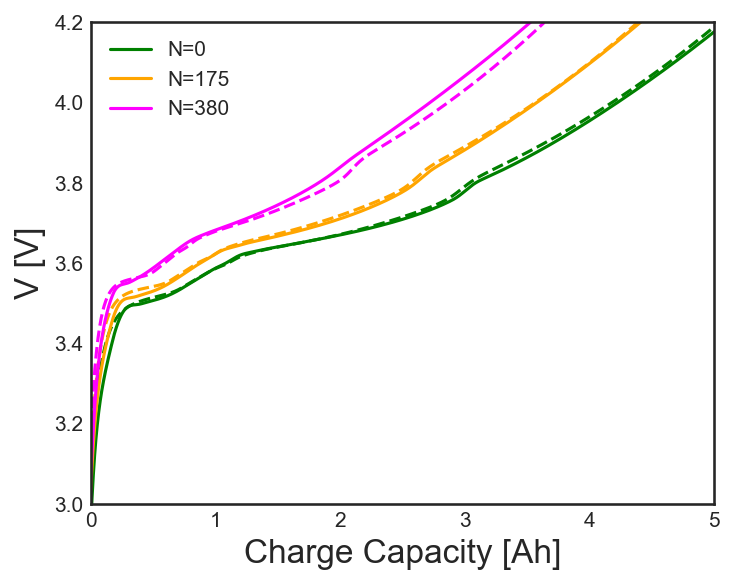

In [105]:
plt.figure(figsize=[5,4])
ax1 =plt.subplot(1,1,1)
# for cyc_no in range(len(N)):
i = 1
for cyc_no in [0,5,10]:
# for cyc_no in [0,10]:
    print(cyc_no)
    plt,ax1 = plot_vol(cyc_no,plt,ax1,i)
    i+=1
ax1.legend(['N=0','N=175','N=380'])
plt.tight_layout()
plt.savefig(fig_DIR +'ACC_Vol_plots_'+cell_no)

In [83]:
plt.show()